EMPEZAMOS IMPORTANDO LIBRERIAS Y LOS DATOS HISTORICOS

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [2]:
data = pd.read_excel("C:\\Users\\pacch\\Desktop\\Data\\CodeOp\\Proyecto\\Proyecto_natalidad\\DEMOGRAPHIC_INDICATORS_UN.xlsx", header=1, index_col=None)
df = data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df['Year'] = df['Year'].dt.year
df = df.sort_values(by=['Type', 'Year'])
Countries = df[df['Type'] == 'Country/Area']
Countries = Countries.drop(columns='Population Annual Doubling Time (years)')

EXTRAIGO SOLO LAS COLUMNAS QUE USARÉ

In [3]:
columns = ['Region, subregion, country or area *', 
            'Year',
            'Total Population, as of 1 July (thousands)',
            'Population Density, as of 1 July (persons per square km)',
            'Population Sex Ratio, as of 1 July (males per 100 females)',
            'Median Age, as of 1 July (years)',
            'Natural Change, Births minus Deaths (thousands)',
            'Population Growth Rate (percentage)',
            'Births (thousands)', 
            'Births by women aged 15 to 19 (thousands)',
            'Crude Birth Rate (births per 1,000 population)',
            'Total Fertility Rate (live births per woman)',
            'Net Reproduction Rate (surviving daughters per woman)',
            'Mean Age Childbearing (years)',
            'Sex Ratio at Birth (males per 100 female births)',
            'Total Deaths (thousands)',
            'Crude Death Rate (deaths per 1,000 population)',
            'Life Expectancy at Birth, both sexes (years)',
            'Female Life Expectancy at Birth (years)',
            'Life Expectancy at Age 15, both sexes (years)',
            'Life Expectancy at Age 65, both sexes (years)',
            'Life Expectancy at Age 80, both sexes (years)',
            'Infant Deaths, under age 1 (thousands)',
            'Under-Five Deaths, under age 5 (thousands)',
            'Infant Mortality Rate (infant deaths per 1,000 live births)',
            'Mortality before Age 60, both sexes (deaths under age 60 per 1,000 live births)',
            'Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)',
            'Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)',
            'Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)',
            'Net Migration Rate (per 1,000 population)'
]

Countries = Countries[columns]

AHORA HACEMOS EL EDA

In [4]:
Countries.columns

Index(['Region, subregion, country or area *', 'Year',
       'Total Population, as of 1 July (thousands)',
       'Population Density, as of 1 July (persons per square km)',
       'Population Sex Ratio, as of 1 July (males per 100 females)',
       'Median Age, as of 1 July (years)',
       'Natural Change, Births minus Deaths (thousands)',
       'Population Growth Rate (percentage)', 'Births (thousands)',
       'Births by women aged 15 to 19 (thousands)',
       'Crude Birth Rate (births per 1,000 population)',
       'Total Fertility Rate (live births per woman)',
       'Net Reproduction Rate (surviving daughters per woman)',
       'Mean Age Childbearing (years)',
       'Sex Ratio at Birth (males per 100 female births)',
       'Total Deaths (thousands)',
       'Crude Death Rate (deaths per 1,000 population)',
       'Life Expectancy at Birth, both sexes (years)',
       'Female Life Expectancy at Birth (years)',
       'Life Expectancy at Age 15, both sexes (years)',
       

In [5]:
numericas = list(Countries.drop(columns='Region, subregion, country or area *'))
Countries[numericas] = Countries[numericas].apply(pd.to_numeric, errors='coerce')
print(Countries.shape)

(17538, 30)


Verificación de la distribución de los datos

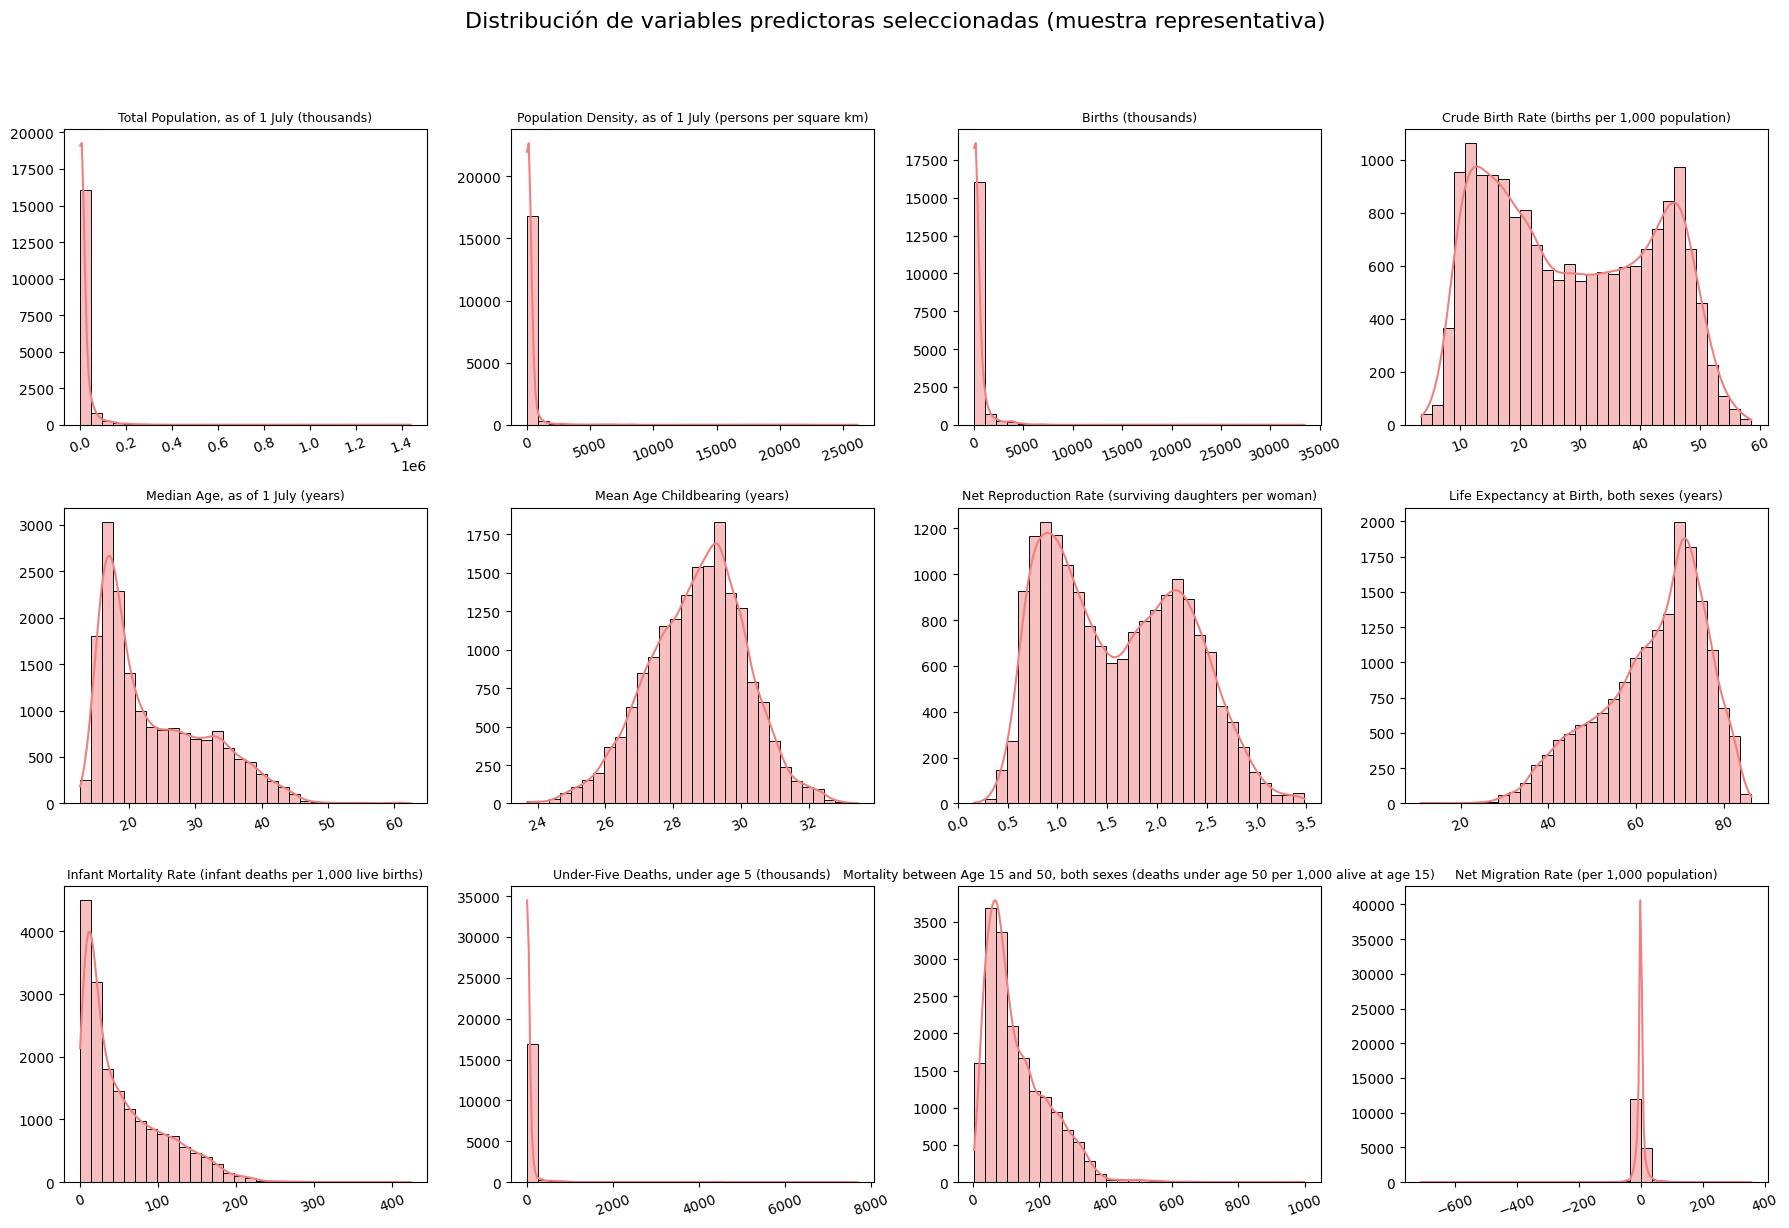

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecciono variables representativas para graficar
variables_seleccionadas = [
    'Total Population, as of 1 July (thousands)',
    'Population Density, as of 1 July (persons per square km)',
    'Births (thousands)',
    'Crude Birth Rate (births per 1,000 population)',
    'Median Age, as of 1 July (years)',
    'Mean Age Childbearing (years)',
    'Net Reproduction Rate (surviving daughters per woman)',
    'Life Expectancy at Birth, both sexes (years)',
    'Infant Mortality Rate (infant deaths per 1,000 live births)',
    'Under-Five Deaths, under age 5 (thousands)',
    'Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)',
    'Net Migration Rate (per 1,000 population)'
]

plt.figure(figsize=(18, 12))

for i, col in enumerate(variables_seleccionadas):
    plt.subplot(3, 4, i + 1)
    sns.histplot(Countries[col].dropna(), kde=True, bins=30, color='lightcoral', edgecolor='black')
    plt.title(col, fontsize=9)
    plt.xticks(rotation=20)
    plt.xlabel("")
    plt.ylabel("")

plt.suptitle("Distribución de variables predictoras seleccionadas (muestra representativa)", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
n_paises = Countries['Region, subregion, country or area *'].nunique()
print(f"🌍 Número de países en el dataset: {n_paises}")

🌍 Número de países en el dataset: 237


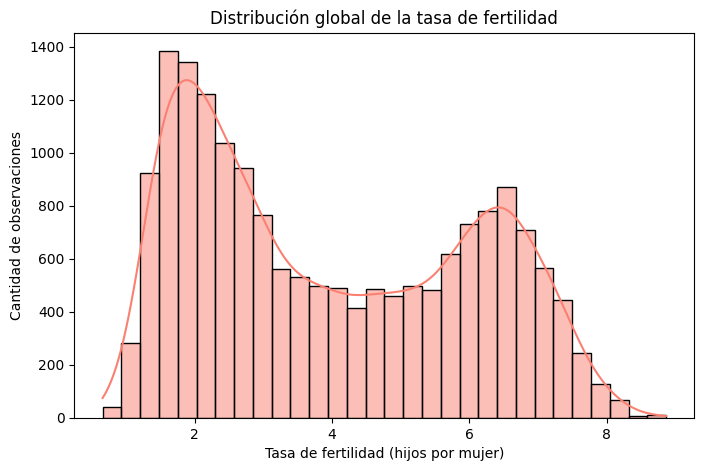

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(Countries['Total Fertility Rate (live births per woman)'].dropna(), kde=True, bins=30, color='salmon')
plt.title("Distribución global de la tasa de fertilidad")
plt.xlabel("Tasa de fertilidad (hijos por mujer)")
plt.ylabel("Cantidad de observaciones")
plt.show()

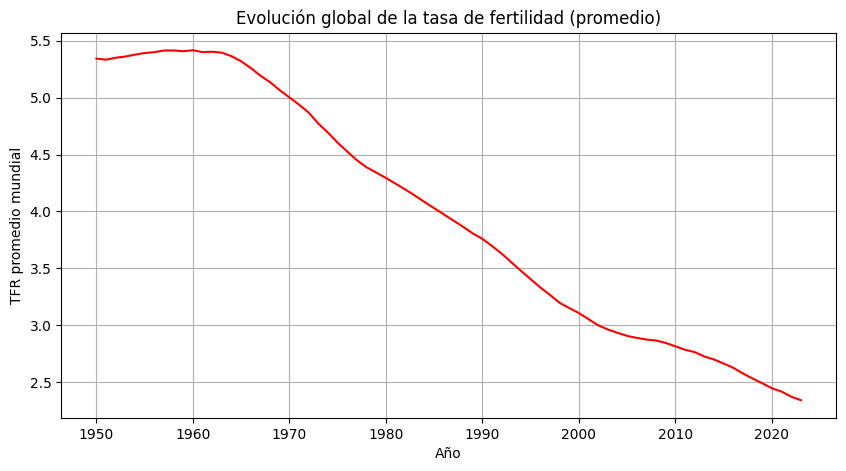

In [ ]:
df_yearly = Countries.groupby('Year')['Total Fertility Rate (live births per woman)'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_yearly, x='Year', y='Total Fertility Rate (live births per woman)', color='red')
plt.title("Evolución global de la tasa de fertilidad (promedio)")
plt.xlabel("Año")
plt.ylabel("TFR promedio mundial")
plt.grid(True)
plt.show()

Voy a probar eliminando unas pocas variables que parecen redundantes a ver cómo actúa el entrenamiento

In [ ]:
paises = Countries['Region, subregion, country or area *'].unique()

features = list(Countries.drop(columns=['Region, subregion, country or area *','Total Fertility Rate (live births per woman)']))
target = 'Total Fertility Rate (live births per woman)'

resultados = []
año_corte = 2005

for pais in paises:
    df_pais = Countries[Countries['Region, subregion, country or area *'] == pais]
    df_pais = df_pais[features + [target]].dropna()
    
    try:
        X = df_pais[features]
        y = df_pais[target]

        train = X[X['Year'] <= año_corte]
        test = X[X['Year'] > año_corte]
        y_train = y[X['Year'] <= año_corte]
        y_test = y[X['Year'] > año_corte]

        if len(test) == 0:
            continue 

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(train)
        X_test_scaled = scaler.transform(test)

        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)
        y_pred_test = modelo.predict(X_test_scaled)

        resultados.append({
            'País': pais,
            'MSE': mean_squared_error(y_test, y_pred_test),
            'MAE': mean_absolute_error(y_test, y_pred_test),
            'R2': r2_score(y_test, y_pred_test),
            'Observaciones_test': len(y_test)
        })

    except Exception as e:
        print(f'Error en {pais}: {e}')
        continue

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='R2', ascending=False)
print(df_resultados)
print(df_resultados.shape)

,País,MSE,MAE,R2,Observaciones_test
139,Holy See,0.000000,0.000000,1.000000,18
123,Guernsey,0.000002,0.001227,0.999765,18
132,United Kingdom,0.000006,0.001929,0.999635,18
225,Nauru,0.000070,0.006808,0.999172,18
213,United States of America,0.000022,0.003473,0.999048,18
...,...,...,...,...,...
101,Oman,0.352950,0.467878,-12.314159,18
100,Lebanon,0.062706,0.166339,-12.555460,18
22,Central African Republic,0.375092,0.318197,-47.653459,18
75,Iran (Islamic Republic of),1.877254,0.536709,-126.989526,18


(237, 5)


In [ ]:
df_resultados['Calidad_modelo'] = df_resultados['R2'].apply(lambda r: 'Buena' if r >= 0.7 else 'Mala')

buenos_modelos = df_resultados[df_resultados['R2'] >= 0.7]

print(f"{len(buenos_modelos)} de {len(df_resultados)} países tienen un modelo con R² ≥ 0.7")

146 de 237 países tienen un modelo con R² ≥ 0.7


In [ ]:
df_modelo = Countries.dropna(subset=features + [target]).copy()
X = df_modelo[features]
y = df_modelo[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
y_pred = modelo.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2 : {r2:.3f}")

MAE: 0.097
MSE: 0.027
R2 : 0.993


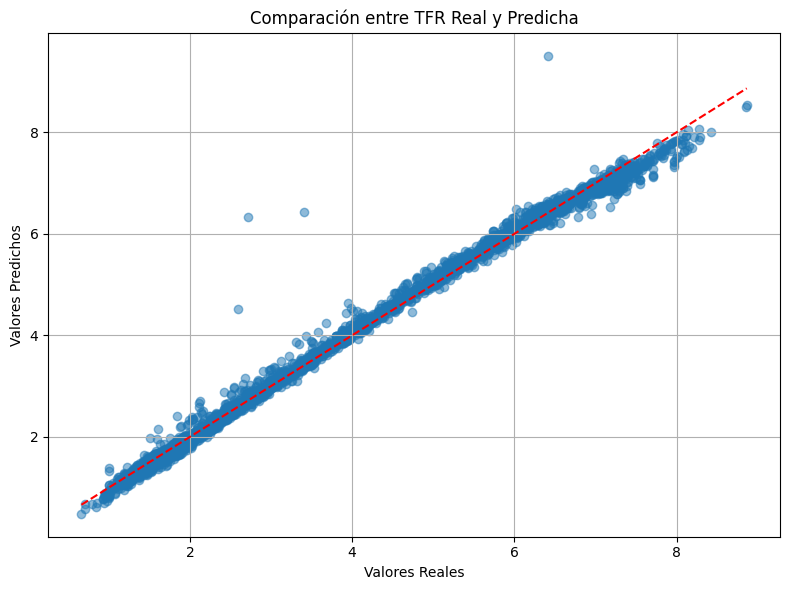

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación entre TFR Real y Predicha")
plt.grid(True)
plt.tight_layout()

In [15]:
un_pred = pd.read_excel("C:\\Users\\pacch\\Desktop\\Data\\CodeOp\\Proyecto\\Proyecto_natalidad\\DEMOGRAPHIC_PREDICTIONS.xlsx", header=1, index_col=None)
df2 = un_pred
df2['Year'] = pd.to_datetime(df2['Year'], format='%Y')
df2['Year'] = df2['Year'].dt.year
df2 = df2.sort_values(by=['Type', 'Year'])
Countries2 = df2[df2['Type'] == 'Country/Area']
Countries2 = Countries2.drop(columns='Population Annual Doubling Time (years)')


Countries2 = Countries2.drop(columns=['Index', 'Variant', 'Notes', 'Location code', 'ISO3 Alpha-code', 'ISO2 Alpha-code', 'SDMX code**', 'Type', 'Parent code'])


columns = ['Region, subregion, country or area *', 
            'Year',
            'Total Population, as of 1 July (thousands)',
            'Population Density, as of 1 July (persons per square km)',
            'Population Sex Ratio, as of 1 July (males per 100 females)',
            'Median Age, as of 1 July (years)',
            'Natural Change, Births minus Deaths (thousands)',
            'Population Growth Rate (percentage)',
            'Births (thousands)', 
            'Births by women aged 15 to 19 (thousands)',
            'Crude Birth Rate (births per 1,000 population)',
            'Total Fertility Rate (live births per woman)',
            'Net Reproduction Rate (surviving daughters per woman)',
            'Mean Age Childbearing (years)',
            'Sex Ratio at Birth (males per 100 female births)',
            'Total Deaths (thousands)',
            'Crude Death Rate (deaths per 1,000 population)',
            'Life Expectancy at Birth, both sexes (years)',
            'Female Life Expectancy at Birth (years)',
            'Life Expectancy at Age 15, both sexes (years)',
            'Life Expectancy at Age 65, both sexes (years)',
            'Life Expectancy at Age 80, both sexes (years)',
            'Infant Deaths, under age 1 (thousands)',
            'Under-Five Deaths, under age 5 (thousands)',
            'Infant Mortality Rate (infant deaths per 1,000 live births)',
            'Mortality before Age 60, both sexes (deaths under age 60 per 1,000 live births)',
            'Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)',
            'Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)',
            'Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)',
            'Net Migration Rate (per 1,000 population)'
]

Countries2 = Countries2[columns]

numericas2 = list(Countries2.drop(columns='Region, subregion, country or area *'))
Countries2[numericas2] = Countries2[numericas2].apply(pd.to_numeric, errors='coerce')
df_onu = Countries2

In [ ]:
features = list(Countries.drop(columns=['Region, subregion, country or area *','Total Fertility Rate (live births per woman)']))
target = 'Total Fertility Rate (live births per woman)'
año_corte = 2005

predicciones = []

paises = Countries['Region, subregion, country or area *'].unique()

for pais in paises:
    df_train = Countries[Countries['Region, subregion, country or area *'] == pais].dropna()
    df_test = Countries2[Countries2['Region, subregion, country or area *'] == pais].dropna()

    if df_train.empty or df_test.empty:
        continue

    try:
        X_train = df_train[features]
        y_train = df_train[target]
        X_test = df_test[features]
        y_test = df_test[target]

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        y_pred = modelo.predict(X_test_scaled)

        for i in range(len(y_pred)):
            predicciones.append({
                'País': pais,
                'Año': int(df_test.iloc[i]['Year']),
                'TFR_Modelo': y_pred[i],
                'TFR_ONU': y_test.iloc[i]
            })

    except Exception as e:
        print(f"Error en {pais}: {e}")
        continue

df_comparacion = pd.DataFrame(predicciones).dropna()

mae = mean_absolute_error(df_comparacion['TFR_ONU'], df_comparacion['TFR_Modelo'])
rmse = mean_squared_error(df_comparacion['TFR_ONU'], df_comparacion['TFR_Modelo'])
r2 = r2_score(df_comparacion['TFR_ONU'], df_comparacion['TFR_Modelo'])

print("📊 Comparación global modelo vs ONU:")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

metricas_por_pais = df_comparacion.groupby('País').apply(
    lambda g: pd.Series({
        'MAE': mean_absolute_error(g['TFR_ONU'], g['TFR_Modelo']),
        'RMSE': np.sqrt(mean_squared_error(g['TFR_ONU'], g['TFR_Modelo'])),
        'R2': r2_score(g['TFR_ONU'], g['TFR_Modelo']) if g['TFR_ONU'].nunique() > 1 else np.nan
    })
).reset_index()

print(f"\n🌍 Top países con mejor R²:")
print(metricas_por_pais.sort_values(by='R2', ascending=False).head())

print(f"\n✅ Países con R² ≥ 0.7: {(metricas_por_pais['R2'] >= 0.7).sum()} de {len(metricas_por_pais)}")


📊 Comparación global modelo vs ONU:
MAE : 0.403
RMSE: 0.749
R²  : -1.040

🌍 Top países con mejor R²:


C:\Users\pacch\AppData\Local\Temp\ipykernel_22560\1444163882.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metricas_por_pais = df_comparacion.groupby('País').apply(


,País,MAE,RMSE,R2
111,Kazakhstan,0.016083,0.019644,0.995653
218,Tuvalu,0.027377,0.033044,0.990936
4,Andorra,0.006436,0.009571,0.989645
90,Guernsey,0.005128,0.006110,0.982730
84,Greece,0.006357,0.006786,0.978596



✅ Países con R² ≥ 0.7: 36 de 237


Me quedo con linear

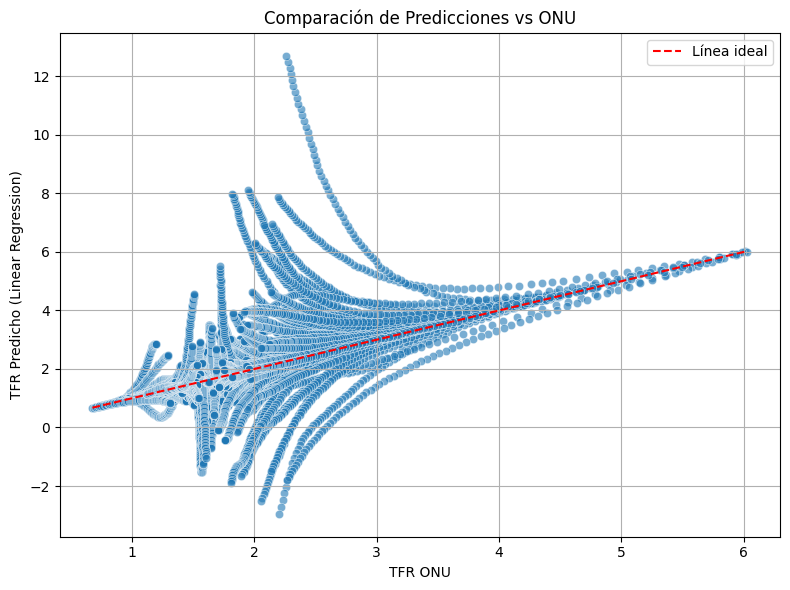

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_comparacion, x='TFR_ONU', y='TFR_Modelo', alpha=0.6)
plt.plot([df_comparacion['TFR_ONU'].min(), df_comparacion['TFR_ONU'].max()],
         [df_comparacion['TFR_ONU'].min(), df_comparacion['TFR_ONU'].max()],
         color='red', linestyle='--', label='Línea ideal')
plt.xlabel('TFR ONU')
plt.ylabel('TFR Predicho (Linear Regression)')
plt.title('Comparación de Predicciones vs ONU')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

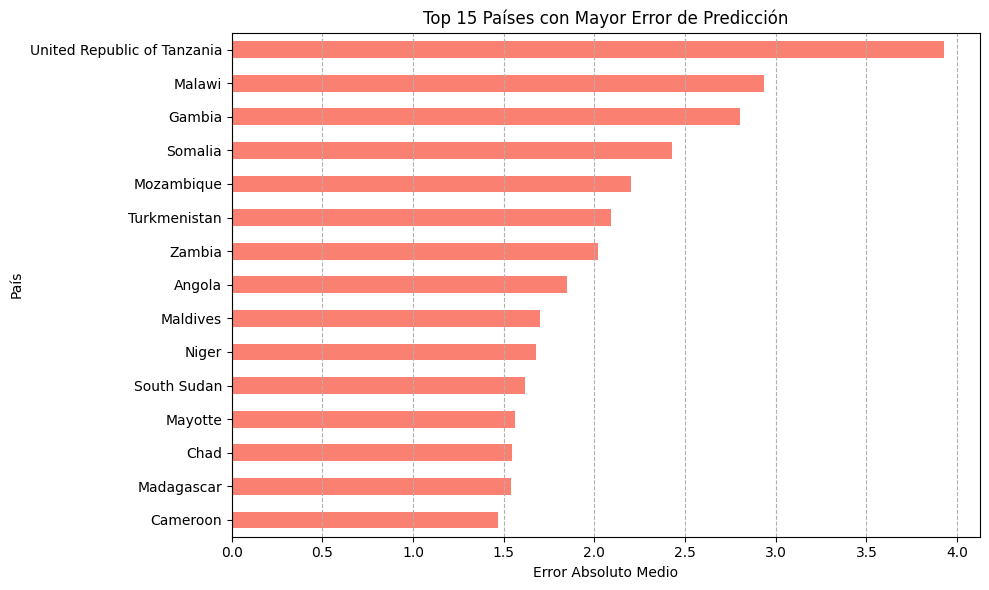

In [ ]:
df_comparacion_lr = df_comparacion
df_comparacion_lr['Error_Absoluto'] = abs(df_comparacion_lr['TFR_ONU'] - df_comparacion_lr['TFR_Modelo'])
errores_top = df_comparacion_lr.groupby('País')['Error_Absoluto'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
errores_top.plot(kind='barh', color='salmon')
plt.xlabel('Error Absoluto Medio')
plt.title('Top 15 Países con Mayor Error de Predicción')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

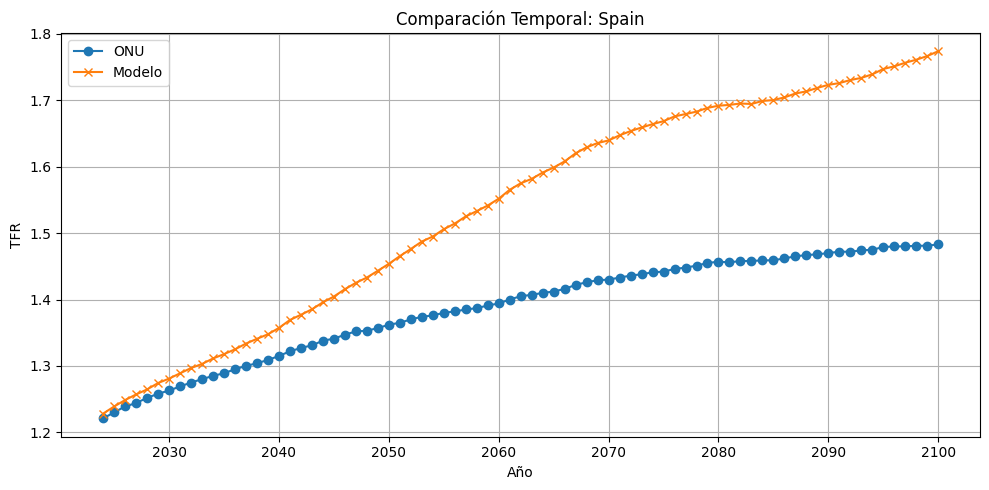

In [ ]:
pais = "Spain" 

df_pais = df_comparacion_lr[df_comparacion_lr['País'] == pais]

plt.figure(figsize=(10, 5))
plt.plot(df_pais['Año'], df_pais['TFR_ONU'], label='ONU', marker='o')
plt.plot(df_pais['Año'], df_pais['TFR_Modelo'], label='Modelo', marker='x')
plt.title(f'Comparación Temporal: {pais}')
plt.xlabel('Año')
plt.ylabel('TFR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\pacch\AppData\Local\Temp\ipykernel_22560\1422473726.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_comparacion_lr, x='Año', y='TFR_Modelo', ci=None, estimator='mean')


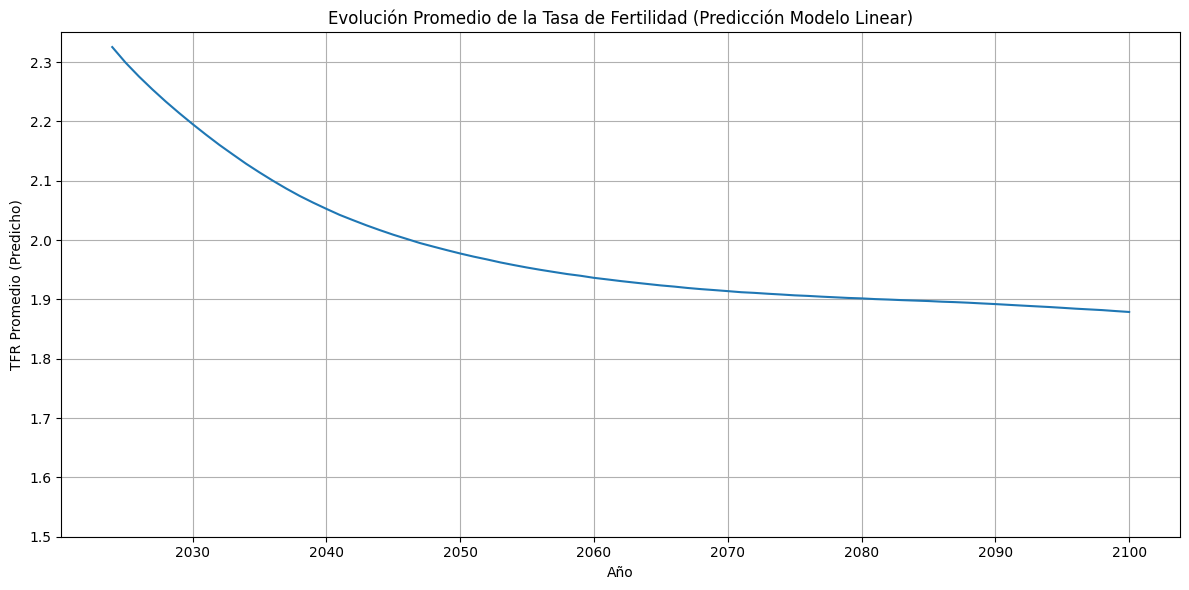

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_comparacion_lr, x='Año', y='TFR_Modelo', ci=None, estimator='mean')
plt.title('Evolución Promedio de la Tasa de Fertilidad (Predicción Modelo Linear)')
plt.xlabel('Año')
plt.ylabel('TFR Promedio (Predicho)')
plt.ylim(1.5, 2.35)  
plt.grid(True)
plt.tight_layout()
plt.show()

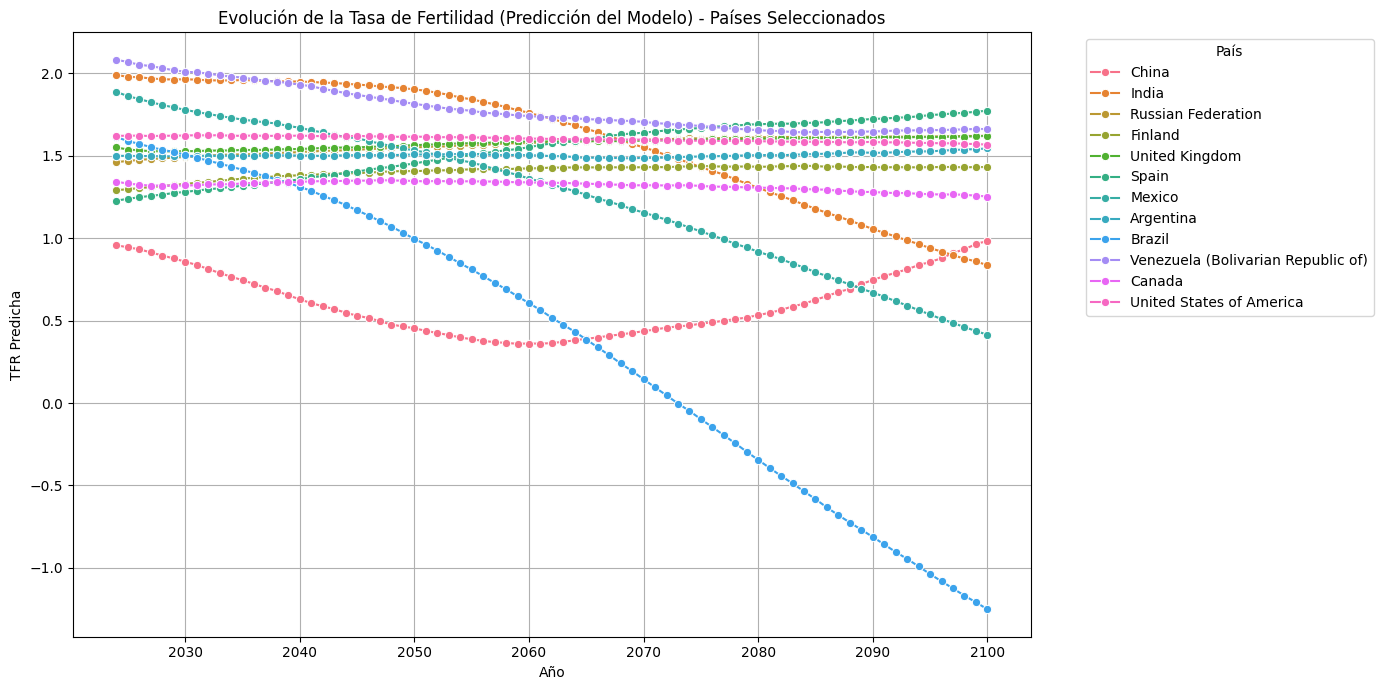

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

paises = [
    'United States of America', 'Spain', 'United Kingdom', 'Russian Federation', 
    'India', 'Venezuela (Bolivarian Republic of)', 'Argentina', 'Brazil', 
    'Mexico', 'Finland', 'Canada', 'China'
]

df_seleccion = df_comparacion_lr[df_comparacion_lr['País'].isin(paises)]

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_seleccion, x='Año', y='TFR_Modelo', hue='País', marker='o')

plt.title('Evolución de la Tasa de Fertilidad (Predicción del Modelo) - Países Seleccionados')
plt.xlabel('Año')
plt.ylabel('TFR Predicha')
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_pred = df_comparacion_lr

resumen_riesgo = df_pred.groupby('País').agg(
    TFR_minima=('TFR_Modelo', 'min'),
    TFR_maxima=('TFR_Modelo', 'max'),
    TFR_promedio=('TFR_Modelo', 'mean')
).reset_index()

def clasificar_riesgo(min_tfr):
    if min_tfr < 1.0:
        return 'Alto'
    elif min_tfr < 2.1:
        return 'Medio'
    else:
        return 'Bajo'

resumen_riesgo['Riesgo_TFR'] = resumen_riesgo['TFR_minima'].apply(clasificar_riesgo)

resumen_riesgo = resumen_riesgo.sort_values(by='TFR_minima')

print(resumen_riesgo.head()) 

,País,TFR_minima,TFR_maxima,TFR_promedio,Riesgo_TFR
136,Mayotte,-2.950160,4.566638,1.492166,Alto
126,Madagascar,-2.518288,3.905118,1.142205,Alto
216,Turkmenistan,-1.892834,2.629202,-0.018558,Alto
40,Chad,-1.792391,6.013544,2.008181,Alto
199,South Sudan,-1.650821,3.787569,0.848297,Alto


In [41]:
resumen_riesgo.sort_values(by='TFR_minima', ascending=False).tail(10)

,País,TFR_minima,TFR_maxima,TFR_promedio,Riesgo_TFR
46,Colombia,-1.041060,1.638008,0.636823,Alto
220,Uganda,-1.184879,4.158370,1.484314,Alto
28,Brazil,-1.250900,1.612448,0.389671,Alto
21,Benin,-1.503489,4.474841,1.733382,Alto
129,Maldives,-1.525117,1.551648,-0.150236,Alto
199,South Sudan,-1.650821,3.787569,0.848297,Alto
40,Chad,-1.792391,6.013544,2.008181,Alto
216,Turkmenistan,-1.892834,2.629202,-0.018558,Alto
126,Madagascar,-2.518288,3.905118,1.142205,Alto
136,Mayotte,-2.950160,4.566638,1.492166,Alto


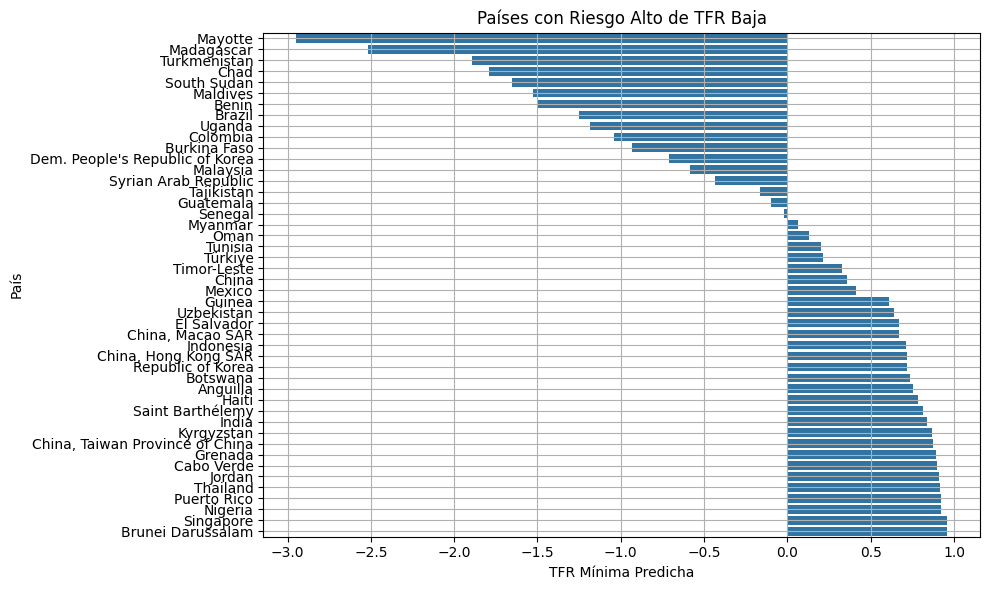

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_alto_riesgo = resumen_riesgo[resumen_riesgo['Riesgo_TFR'] == 'Alto']

plt.figure(figsize=(10, 6))
sns.barplot(data=df_alto_riesgo, x='TFR_minima', y='País', order=df_alto_riesgo.sort_values('TFR_minima')['País'])
plt.title('Países con Riesgo Alto de TFR Baja')
plt.xlabel('TFR Mínima Predicha')
plt.ylabel('País')
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
df_comparacion.head()

,País,Año,TFR_Modelo,TFR_ONU,Error_Absoluto
0,Burundi,2024,4.792707,4.789,0.003707
1,Burundi,2025,4.669044,4.675,0.005956
2,Burundi,2026,4.555954,4.566,0.010046
3,Burundi,2027,4.450139,4.463,0.012861
4,Burundi,2028,4.362389,4.372,0.009611


Ahora con CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

historical_df = Countries.copy()
onu_df = Countries2.copy()

features = list(historical_df.drop(columns=['Region, subregion, country or area *', 'Total Fertility Rate (live births per woman)']))
target = 'Total Fertility Rate (live births per woman)'

predicciones = []

paises = sorted(set(historical_df['Region, subregion, country or area *']).intersection(set(onu_df['Region, subregion, country or area *'])))

for pais in paises:
    df_train = historical_df[historical_df['Region, subregion, country or area *'] == pais].dropna()
    df_test = onu_df[onu_df['Region, subregion, country or area *'] == pais].dropna()

    if df_train.empty or df_test.empty:
        continue

    try:
        X_train = df_train[features]
        y_train = df_train[target]
        X_test = df_test[features]
        y_test = df_test[target]

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        modelo = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_state=42)
        modelo.fit(X_train_scaled, y_train)

        y_pred = modelo.predict(X_test_scaled)

        for i in range(len(y_pred)):
            predicciones.append({
                'País': pais,
                'Año': int(df_test.iloc[i]['Year']),
                'TFR_Modelo': y_pred[i],
                'TFR_ONU': y_test.iloc[i]
            })

    except Exception as e:
        print(f"Error en {pais}: {e}")
        continue

df_comparacion_cb = pd.DataFrame(predicciones).dropna()

mae_cb = mean_absolute_error(df_comparacion_cb['TFR_ONU'], df_comparacion_cb['TFR_Modelo'])
rmse_cb = mean_squared_error(df_comparacion_cb['TFR_ONU'], df_comparacion_cb['TFR_Modelo'])
r2_cb = r2_score(df_comparacion_cb['TFR_ONU'], df_comparacion_cb['TFR_Modelo'])

print("📊 Comparación global modelo CatBoost vs ONU:")
print(f"MAE : {mae_cb:.3f}")
print(f"RMSE: {rmse_cb:.3f}")
print(f"R²  : {r2_cb:.3f}")

print(df_comparacion_cb.head())

NameError: name 'hola' is not defined

In [35]:
df_comparacion_lr.head()

,País,Año,TFR_Modelo,TFR_ONU,Error_Absoluto
0,Burundi,2024,4.792707,4.789,0.003707
1,Burundi,2025,4.669044,4.675,0.005956
2,Burundi,2026,4.555954,4.566,0.010046
3,Burundi,2027,4.450139,4.463,0.012861
4,Burundi,2028,4.362389,4.372,0.009611
